# Vehicle Detection



In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import collections
from glob import glob
%matplotlib inline

## 1 Define a function to compute binned color features 

In [2]:
def bin_spatial(img, size=(16, 16)):
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

## 2 Define a function to compute color histogram features

In [3]:
def color_hist(img, nbins=32):
    bins_range=(0, 1.0) if img.dtype == np.float32 else (0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## 3 Define a function to return HOG features and visualization

In [4]:
def get_hog_features(img, orient=32,
                     pix_per_cell=16,
                     cell_per_block=2,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
def convert_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

Test HOG and plot them

C:\Users\biu\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


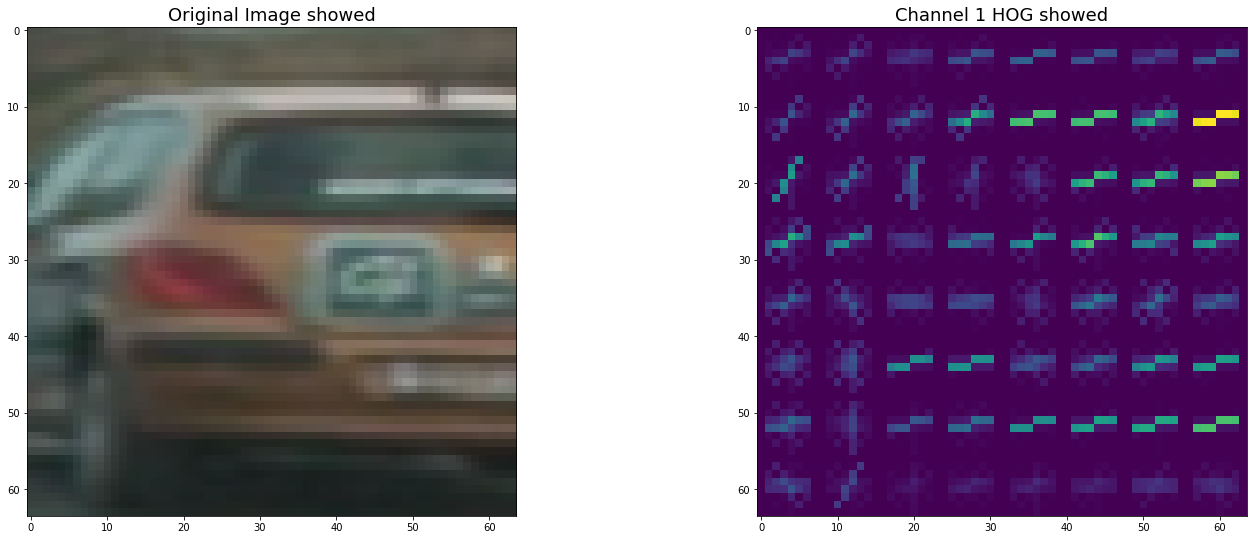

In [5]:
tes_file_path = "Data/vehicles/GTI_Right/image0775.png"
test_img = mpimg.imread(tes_file_path)
conv = convert_color(test_img, 'RGB')
features,img = get_hog_features(conv[:,:,0], 9, 8, 2, vis=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_img)
ax1.set_title('Original Image showed', fontsize=18)
ax2.imshow(img)
ax2.set_title('Channel 1 HOG showed', fontsize=18)

## 4 Define find_cars function to  extract features using hog sub-sampling and make predictions

In [6]:
def find_cars(img, color_space, ystart, ystop, scale, model, X_scaler,
              show_all=False):
    pix_per_cell = 16
    orient = 32
    pix_per_cell = 16
    cell_per_block = 2
    hist_bins = 32
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []
    global count
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=(16,16))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))
            test_prediction = model.predict(test_features)

            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_list.append(box)
                #mpimg.imsave("output-images/img-{}.jpg".format(count), subimg)
                #count += 1
                #cv2.rectangle(draw_img, box[0], box[1],(0,0,255),6)

    return box_list

# extract features from one image
# Have this function call bin_spatial() and color_hist()
def extract_features(image, color_space='RGB', spatial_size=(16,16),
                     hog_channel='ALL'):

    file_features = []
    feature_image = convert_color(image, color_space)

    spatial_features = bin_spatial(feature_image, size=(16,16))
    file_features.append(spatial_features)

    # Apply color_hist()
    #hist_features = color_hist(feature_image, nbins=hist_bins)
    #file_features.append(hist_features)

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                 orient, pix_per_cell, cell_per_block,
                                                 vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                        pix_per_cell, cell_per_block, vis=False,
                                        feature_vec=True)
        # Append the new feature vector to the features list
    file_features.append(hog_features)
    assert (file_features != [])
    return np.concatenate(file_features)


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.33, 0.2)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    x_start_stop = [np.int(i) for i in x_start_stop]
    y_start_stop = [np.int(i) for i in y_start_stop]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [11]:
def annotate_cars_in_image( model, scalar, img): 
        
        image_size = img.shape
        box_list = []
        def search(ybeg, yend, scale):
            return find_cars(img, 'YCrCb', ybeg, yend, scale,
                             model, scalar,
                             show_all=False)

        box_list += search(370, 500, 1)
        box_list += search(400, 580, 2)
        
        
        # Iterate through the bounding boxes
        for bbox in box_list:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 3)
        
        return img


# Training

In [12]:
def trainning(vehicle_folder = 'Data/vehicles', nonvehicle_folder = 'Data/non-vehicles'):
    pix_per_cell = 16
    orient = 32
    pix_per_cell = 16
    cell_per_block = 2
    hist_bins = 32
    color_space = 'YCrCb'

    model = LinearSVC()

    vehicle_paths = []
    nonvehicle_paths = []
    suffix_list=['.jpeg', '.png', '.jpg']

    for root, dirs, files in os.walk(vehicle_folder):
        vehicle_paths += [os.path.join(root, f) for f in files if os.path.splitext(f)[1] in suffix_list]

    for root, dirs, files in os.walk(nonvehicle_folder):
        nonvehicle_paths += [os.path.join(root, f) for f in files if os.path.splitext(f)[1] in suffix_list]

    vehicle_imgs = []
    nonvehicle_imgs = []

    for img_path in vehicle_paths:
        img = mpimg.imread(img_path)
        vehicle_imgs.append(img)

    for img_path in nonvehicle_paths:
        img = mpimg.imread(img_path)
        nonvehicle_imgs.append(img)

    X = np.vstack((vehicle_imgs, nonvehicle_imgs))
    y = np.hstack((np.ones(len(vehicle_imgs)),np.zeros(len(nonvehicle_imgs))))

    
    print("Prepare process with {} images".format(len(X)))
    features_array = []
    for i in X:
        features_array.append(extract_features(i, color_space=color_space, hog_channel='ALL'))
    print("feature length", len(features_array[0]), "feature shape", features_array[0].shape)
    features = np.array(features_array).astype(np.float64)
    scalar = StandardScaler().fit(features)
    scaled_X = scalar.transform(features)

    stat = np.random.randint(0, 100)
    scaled_X, y = shuffle(scaled_X, y)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                                test_size=0.3,
                                                                random_state=stat)

    print("Training...")
    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)

    print("Testing score: {}".format(score))

    print("Save into project5_model.pkl")
    f = open('project5_model.pkl', 'wb') 
    pickle.dump((model,scalar), f)
    f.close()

C:\Users\biu\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


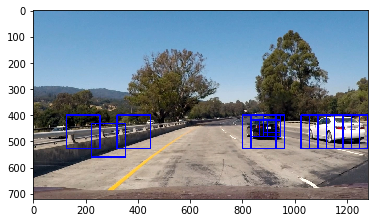

In [13]:
train_model = False
if train_model == True:
    trainning(vehicle_folder = 'Data/vehicles', nonvehicle_folder = 'Data/non-vehicles')

f = open('project5_model.pkl', 'rb')
model, scalar = pickle.load(f)
test_image = mpimg.imread('test_images/test1.jpg')
f.close()
annotated = annotate_cars_in_image(model, scalar, test_image)
plt.imshow(annotated)

# Video

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = collections.deque(maxlen=7)
f = open('project5_model.pkl', 'rb')
model, scalar = pickle.load(f)
history = collections.deque(maxlen=7)
f.close()

def annotate_cars_in_video(img, model = model , scalar = scalar, history = history ):
        image_size = img.shape
        box_list = []
        def search(ybeg, yend, scale):
            return find_cars(img, 'YCrCb', ybeg, yend, scale,
                             model, scalar,
                             show_all=False)

        box_list += search(370, 500, 1)
        box_list += search(400, 580, 2)
        
        heat = np.zeros((720, 1280))
        for box in box_list:
            heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        history.append(heat)
        
        heat = np.sum(np.array(history), axis=0)
        if len(history) == history.maxlen:
            # should stay at least 4 frames
            heat[heat <= 3] = 0

        pixels, ncars = label(heat)

        new_boxes = []
        for i in range(1, ncars+1):
            nonzero = (pixels == i).nonzero()

            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            new_boxes.append(box)

        # Iterate through the bounding boxes using new_boxes
        for bbox in new_boxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 3)
        return img

def process_video(video_filename):
    output =  video_filename + "_Vehicel_Detetected.mp4"
    input_clip = VideoFileClip(video_filename)#.subclip(21,23)
    clip = input_clip.fl_image(annotate_cars_in_video)
    #clip = input_clip.fl_image(save_image)
    %time clip.write_videofile(output, audio=False)

process_video('project_video.mp4')

[MoviePy] >>>> Building video project_video.mp4_Vehicel_Detetected.mp4
[MoviePy] Writing video project_video.mp4_Vehicel_Detetected.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:51<00:00,  2.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video.mp4_Vehicel_Detetected.mp4 

Wall time: 7min 53s
